In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Mostrar código</button>''', raw=True)

Mostrar código

## Aprendizaje de Máquina
### Proyecto Final - Reconocimiento de Dígitos usando Pocas Coordenadas
#### María Fernanda Alcalá Durand - 118716

## Los datos - Pendigit



He decidido trabajar con los datos de Pendigit, obtenidos del repositorio de bases de datos de UCI. En el sitio web de los datos, se explica que fueron obtenidos de 44 diferentes personas, a las cuales se pidió que escribieran de manera aleatoria 250 números. Esto se realizó en un dispositivo tipo tablet que mide las coordenadas en las cuales se encuentra la pluma, cada 100 milisegundos. Se eliminaron los primeros intentos, debido a que se consideró que los escritores no estaban familiarizados con la tecnología.

Casi cualquier dispositivo inteligente cuenta con una pantalla táctil, así que es completamente factible y aplicable al mundo real - en lo personal, yo tomo mis apuntes a mano en una tablet pues es sumamente complicado hacer gráficas y fórmulas en ella. Sin embargo, me encantaría que tales apuntes fueran "buscables", poder buscar en qué parte hablo de un cierto tema. Por otro lado, como ciertos dispositivos suelen tener un agente humano que puede corregir a la máquina si se equivoca, además de que no cuentan con tanta RAM, es preferible obtener rapidez en el modelo de clasificación.

Los datos son presentados en ocho pares de coordenadas (16 variables numéricas) que pertenecen al rango [0,100] y una categórica que pertenece al rango [0,1,...,9]. Podemos echar un primer vistazo a los datos:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import neurolab as nl
#from pybrain.datasets import SupervisedDataSet
#from pybrain.supervised.trainers import BackpropTrainer
#from pybrain.tools.shortcuts import buildNetwork
%matplotlib inline

In [3]:
y = []
d = []
with open('pendigits.tra.txt') as f:
    for row in f:
        row = row.replace(' ','').replace('\n','').split(',')
        y.append(row[-1])
        d.append(row[:-1])
d = np.array(d, dtype=int).reshape((8*len(d), 2))
y = np.repeat(np.array(y, dtype=int), 8)

/Users/fernanda/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


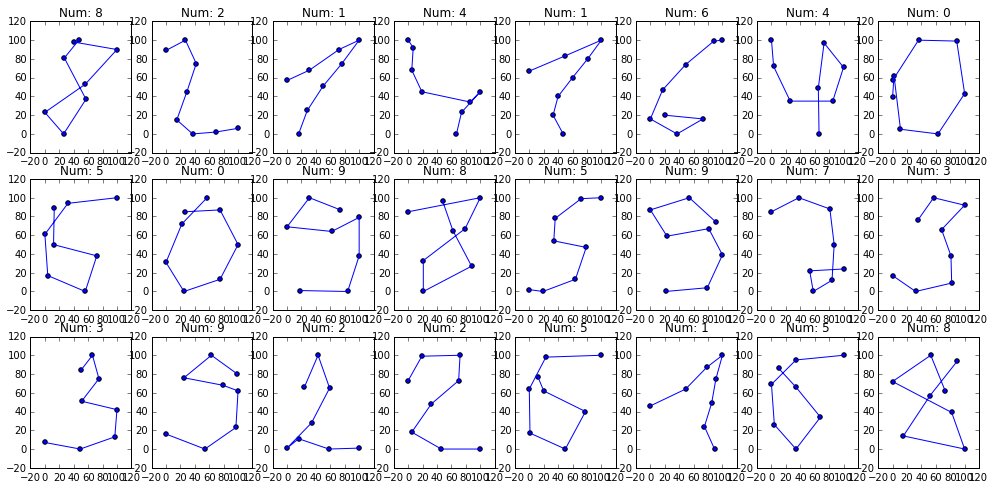

In [4]:
f, ax = plt.subplots(3,8,figsize=(17,8))
ax = ax.flatten()
for i in range(24):
    ini = 8*i
    fin = 8*(i+1)
    ax[i].plot(d[ini:fin,0], d[ini:fin,1])
    ax[i].scatter(d[ini:fin,0], d[ini:fin,1])
    ax[i].set_title('Num: %d' % y[ini])

### Preparando los datos y estableciendo lo que ya sabemos

El conjunto de datos viene pre-separado en train (7494 instancias) y test (3498 instancias). Esto representa una proporción aproximada de 70%-30%.

Por otro lado, dado que todas las columnas representan puntos en un espacio cuadrado de tamaño fijo, probablemente es mejor trabajar con datos no normalizados - los puntos cercanos al (50,50), el centro de la gráfica, nos dan exactamente la misma información que los lejanos.

In [5]:
#LEEMOS LOS DATOS, SEPARADOS YA EN TRAIN Y TEST
train_data=np.asarray(pd.read_csv('pendigits.tra.txt',header=None))
train_x=train_data[:,0:16]
train_y=train_data[:,16]

test_data=np.asarray(pd.read_csv('pendigits.tes.txt',header=None))
test_x=test_data[:,0:16]
test_y=test_data[:,16]

## Los modelos

### Máquina de Soporte Vectorial

Probaremos con los siguientes valores de C para buscar el clasificador que dé menor error:

$$
C = (0.01,0.5,1,5,10,100,1000,100000)
$$

In [6]:
#probar con diferentes C para ver la que dé menor error
c_values=(0.01,0.5,1,5,10,100,1000,100000)
trues_svm=[]
for i in range(len(c_values)):
    clf_1=SVC(C=c_values[i],kernel='rbf')
    clf_1.fit(train_x,train_y)
    prediction = clf_1.predict(test_x[0:len(test_x)])
    trues_svm.append(sum(test_y==prediction))
print("Aciertos con SVM, para cada valor de C propuesto: " + str(trues_svm))

Aciertos con SVM, para cada valor de C propuesto: [365, 365, 479, 498, 498, 498, 498, 498]


Como podemos observar, parece el número de aciertos converge a un máximo al aumentar C - esto significa, generalmente, overfitting. A pesar de que el modelo se está esforzando por clasificar correctamente cada punto, presenta un 14.23% de precisión al predecir nuevos valores - esto es porque, en general, las SVM separan dos clases. Tomando en cuenta que una clase es el 10% de los datos, el desempeño de este algoritmo es, a lo más, complicado de interpretar; además de que se necesitarían 10 SVM para separar correctamente cada una de las clases, y esto es muy complejo.

### K Vecinos Cercanos

Probaremos con los siguientes valores de número de vecinos para buscar el clasificador que dé menor error:

$$
n = (1,2,3,4,5,10,20)
$$

In [7]:
#buscar un buen número de neighbors que me da menor error
neigh_values=(1,2,3,4,5,10,20)
trues_knn=[]
for i in range(len(neigh_values)):
    clf_2 = KNeighborsClassifier(n_neighbors=neigh_values[i])
    clf_2.fit(train_x,train_y)
    prediction=clf_2.predict(test_x[0:len(test_x)])
    trues_knn.append(sum(test_y==prediction))
print("Vecinos propuestos: " + str(neigh_values))        
print("Aciertos con KNN, para cada valor de número de vecinos propuesto: " + str(trues_knn))

Vecinos propuestos: (1, 2, 3, 4, 5, 10, 20)
Aciertos con KNN, para cada valor de número de vecinos propuesto: [3419, 3406, 3421, 3416, 3414, 3411, 3387]


El valor más alto de precisión fue obtenido igualmente por casi todos los modelos en las repeticiones hechas en experimentación; este valor de 97.65%. Por parsimonia, se usaría el modelo más sencillo: un solo vecino cercano.

También cabe destacar que KNN fue el modelo más rápido. Esto es invaluable si queremos procesar caracteres en el momento en el que van siendo escritos.

Es muy evidente que el modelo de vecinos cercanos tiene una victoria aplastante frente a la Máquina de Soporte Vectorial. Pero, ¿podremos encontrar una red neuronal que defienda el honor?

### Red Neuronal

In [8]:
input = train_x.astype(float)
#y= train_y
y = np.asarray(pd.get_dummies(train_y))
size=len(train_x)
target = y.reshape(size,10)

#ANALISIS PRELIMINAR
#Con el siguiente código exploramos el comportamiento de
#distintas redes con diferente número de neuronas en la capa oculta

#hidden_neurons=(1,2,3,4,5,10,15,16)
#errors_ann=[]

#for i in range(len(hidden_neurons)):
#    net = nl.net.newff([[0,100]]*16, [hidden_neurons[i], 10])
#    net.trainf = nl.train.train_rprop
#    print('con estas nauronas: ' + str(hidden_neurons[i]))
#    print(net.train(input, target, show=10, epochs = 100))
#    #error.append(net.train(input, target, show=10, epochs = 100))

#Se obtuvo que muchas de las distintas redes convergen al mismo ECM, ~3371
#menos la de 10 y la de 16, así que exploraremos más esas


#ANALISIS PRELIMINAR
#Con el siguiente código exploramos el comportamiento de
#distintas redes con diferente número de neuronas en la capa oculta

#hidden_neurons=(10,16)
#errors_ann=[]

#for i in range(len(hidden_neurons)):
#    net = nl.net.newff([[0,100]]*16, [hidden_neurons[i], 10])
#    net.trainf = nl.train.train_rprop
#    print('con estas nauronas: ' + str(hidden_neurons[i]))
#    print(net.train(input, target, show=10, epochs = 1000))
#    #error.append(net.train(input, target, show=10, epochs = 100))

# así que usaremos el modelo con 16 neuronas

net = nl.net.newff([[0,100]]*16, [16, 10])
net.trainf = nl.train.train_rprop
net.train(input, target, show=500, epochs = 2500)
out = net.sim(input)

Epoch: 500; Error: 3369.1984309;
Epoch: 1000; Error: 3367.12176083;
Epoch: 1500; Error: 3137.19464659;
Epoch: 2000; Error: 3063.96628371;
Epoch: 2500; Error: 3058.18455989;
The maximum number of train epochs is reached


Se corrieron varias redes neuronales, con distinto número de neuronas en la capa oculta. En la primera fase, se intentaron (1,2,3,4,5,10,15,16) neuronas con solamente 100 epochs. Los mejores concursantes resultaron (10,16).

En una segunda fase, se compararon ambas redes con 2500 epochs. La red con 16 capas llegó a un error mucho menor, así que elegí esa.

La mejor red neuronal, con 16 neuronas en la capa escondida obtuvo un error cuadrático aproximado de 2780. Esto se tradujo en 98.48% de aciertos. Este es un número más alto que el que obtuvimos con el modelo de K-vecinos cercanos, pero a cambio de un tiempo computacional mucho más grande: mientras K-vecinos tarda menos de 10 segundos en entrenar y evaluar en el conjunto de test, la ANN tarda más de dos minutos solamente en entrenar hasta convergencia.

## Pero hagámoslo interesante...

¿Qué pasa si quitamos algunos datos? ¿Podemos saber qué letra es, por ejemplo, con solamente la primera mitad de los trazos?

Para esta sección, usaremos solamente los modelos mejor portados: K-vecinos cercanos y Red Neuronal.

### Sin el último dato

In [9]:
#LEEMOS LOS DATOS, SEPARADOS YA EN TRAIN Y TEST
train_data=np.asarray(pd.read_csv('pendigits.tra.txt',header=None))
train_x=train_data[:,0:14]
train_y=train_data[:,16]

test_data=np.asarray(pd.read_csv('pendigits.tes.txt',header=None))
test_x=test_data[:,0:14]
test_y=test_data[:,16]

#### ANN

In [10]:
input = train_x.astype(float)
y = np.asarray(pd.get_dummies(train_y))
size=len(train_x)
target = y.reshape(size,10)

net = nl.net.newff([[0,100]]*14, [14, 10])
net.trainf = nl.train.train_rprop
net.train(input, target, show=500, epochs = 2500)
out = net.sim(input)

Epoch: 500; Error: 2450.07607504;
Epoch: 1000; Error: 2446.44541449;
Epoch: 1500; Error: 2443.35865798;
Epoch: 2000; Error: 2214.7797538;
Epoch: 2500; Error: 2181.74918467;
The maximum number of train epochs is reached


#### K- Vecinos Cercanos

In [11]:
#buscar un buen número de neighbors que me da menor error
neigh_values=(1,2,3,4,5,10,20)
trues_knn=[]
for i in range(len(neigh_values)):
    clf_2 = KNeighborsClassifier(n_neighbors=neigh_values[i])
    clf_2.fit(train_x,train_y)
    prediction=clf_2.predict(test_x[0:len(test_x)])
    trues_knn.append(sum(test_y==prediction))
print("Aciertos con KNN, para cada valor de número de vecinos propuesto: " + str(trues_knn))

Aciertos con KNN, para cada valor de número de vecinos propuesto: [3405, 3382, 3406, 3411, 3398, 3400, 3370]


Ambos modelos perdieron un poco de precisión - pero mínimo, realmente - KNN ahora tiene un valor alto de 97.5% y ANN de 98.3%. 

No perdimos realmente nada, pero ahora tenemos 12.5% menos datos. El tradeoff entre complejidad y accuracy del modelo parece ser bastante bueno en este nivel.

Sin embargo, curiosamente ANN tardó mucho más tiempo en entrenar, más de veinte minutos incluso, a pesar de que está trabajando con menos datos. Es por esto que solamente seguiré experimentando con KNN.

### n-2 pares de datos

In [12]:
#LEEMOS LOS DATOS, SEPARADOS YA EN TRAIN Y TEST
train_data=np.asarray(pd.read_csv('pendigits.tra.txt',header=None))
train_x=train_data[:,0:12]
train_y=train_data[:,16]

test_data=np.asarray(pd.read_csv('pendigits.tes.txt',header=None))
test_x=test_data[:,0:12]
test_y=test_data[:,16]

In [13]:
#buscar un buen número de neighbors que me da menor error
neigh_values=(1,2,3,4,5,10,20,30,40)
trues_knn=[]
for i in range(len(neigh_values)):
    clf_2 = KNeighborsClassifier(n_neighbors=neigh_values[i])
    clf_2.fit(train_x,train_y)
    prediction=clf_2.predict(test_x[0:len(test_x)])
    trues_knn.append(sum(test_y==prediction))
print("Vecinos propuestos: " + str(neigh_values))    
print("Aciertos con KNN, para cada valor de número de vecinos propuesto: " + str(trues_knn))

Vecinos propuestos: (1, 2, 3, 4, 5, 10, 20, 30, 40)
Aciertos con KNN, para cada valor de número de vecinos propuesto: [3355, 3351, 3370, 3366, 3358, 3347, 3317, 3293, 3259]


Quitando los dos últimos puntos (ahora trabajamos con 6, o visto de otra manera, con 75% de los datos), obtenemos una precisión de 96.34%, lo cual no es nada despreciable a cambio de la rapidez ganada. Es interesante notar que el mejor resultado ya no es obtenido por el modelo con 1-vecino cercano.

### La mitad de los datos

In [14]:
#LEEMOS LOS DATOS, SEPARADOS YA EN TRAIN Y TEST
train_data=np.asarray(pd.read_csv('pendigits.tra.txt',header=None))
train_x=train_data[:,0:8]
train_y=train_data[:,16]

test_data=np.asarray(pd.read_csv('pendigits.tes.txt',header=None))
test_x=test_data[:,0:8]
test_y=test_data[:,16]

In [15]:
#buscar un buen número de neighbors que me da menor error
neigh_values=(1,2,3,4,5,10,20,30,40)
trues_knn=[]
for i in range(len(neigh_values)):
    clf_2 = KNeighborsClassifier(n_neighbors=neigh_values[i])
    clf_2.fit(train_x,train_y)
    prediction=clf_2.predict(test_x[0:len(test_x)])
    trues_knn.append(sum(test_y==prediction))
print("Vecinos propuestos: " + str(neigh_values))    
print("Aciertos con KNN, para cada valor de número de vecinos propuesto: " + str(trues_knn))

Vecinos propuestos: (1, 2, 3, 4, 5, 10, 20, 30, 40)
Aciertos con KNN, para cada valor de número de vecinos propuesto: [3022, 2953, 3058, 3047, 3069, 3054, 3036, 2989, 2959]


Hemos reducido nuestra base al 50% de los datos, y todavía le estamos dando la categoría correcta al 87% de los datos. Al igual que en el modelo anterior, tomando n-2 pares de datos, el mejor categorizador ya no es solamente con 1-vecino, sino que necesita más información.

### Un solo dato... ¿qué tanto podemos saber por el lugar en el que comienzan el trazo?

In [16]:
#LEEMOS LOS DATOS, SEPARADOS YA EN TRAIN Y TEST
train_data=np.asarray(pd.read_csv('pendigits.tra.txt',header=None))
train_x=train_data[:,0:2]
train_y=train_data[:,16]

test_data=np.asarray(pd.read_csv('pendigits.tes.txt',header=None))
test_x=test_data[:,0:2]
test_y=test_data[:,16]

In [17]:
#buscar un buen número de neighbors que me da menor error
neigh_values=(1,2,3,4,5,10,20,30,40,50,60)
trues_knn=[]
for i in range(len(neigh_values)):
    clf_2 = KNeighborsClassifier(n_neighbors=neigh_values[i])
    clf_2.fit(train_x,train_y)
    prediction=clf_2.predict(test_x[0:len(test_x)])
    trues_knn.append(sum(test_y==prediction))
print("Vecinos propuestos: " + str(neigh_values))    
print("Aciertos con KNN, para cada valor de número de vecinos propuesto: " + str(trues_knn))

Vecinos propuestos: (1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60)
Aciertos con KNN, para cada valor de número de vecinos propuesto: [1264, 1254, 1338, 1360, 1348, 1447, 1537, 1557, 1571, 1596, 1586]


Por supuesto que con un solo dato no podemos clasificar correctamente todo - ¿cómo vamos a diferenciar, por ejemplo, el ocho del cero? Al menos yo empiezo ambos en el mismo punto.

## Conclusiones

Comencé este proyecto sabiendo que era una base de datos fácil, y que era precisamente el tipo de problema que podría ser resuelto de una manera espectacular por K-vecinos cercanos - tiene todo el sentido del mundo que todos los doses se parezcan, y que está bastante lejos de los ochos.

Una cosa curiosa que encontré mientras jugaba, fue que SVM se porta terriblemente mal con todos los datos, alcanzando un accuracy de 14%, pero si usamos solamente el primer par de datos, este accuracy sube a 43%. Claro, este número no está siquiera cerca de poder competir con los otros dos modelos, pero es una mejora enorme. Probablemente esté encontrando dos clases de números, los que se empiezan más bien a la derecha (2,3,4,7), o al centro (0,1,8) o a la izquierda (5,6,9).

Creo que lo más importante que podemos obtener de este análisis es que no necesitamos gran información de caracteres escritos: incluso con siete puntos que describan al número, se puede saber con error mínimo cuál caracter es. Asimismo, dada la "alta" accuracy del modelo con un solo dato (más de 40%), si se implementa un algoritmo en dos pasos: un primero que, con el primer punto, obtenga los dígitos más probables (reduciría a menos de la mitad de los dígitos posibles) y después hiciera una predicción basada en un modelo entrenado solamente con el subconjunto de números que empiezan en ese punto, probablemente sería más eficiente, e incluso más rápido. Tal vez así se podría implementar más fácilmente la red neuronal, que tomó demasiado tiempo con los datos originales.

## Especificaciones Técnicas

Este Markdown de Python 2.7 fue ejecutado en Jupyter, en una Macbook 2012, con 10GB de RAM y procesador 2.5 GHz Intel Core i5.

## Bibliografía

Matan, O. et al, Handwritten Character Recognition Using Neural Network Architectures, AT&T Bell Laboratories, N.J.

Saurabh Mathur, Handwritten Character Recognition, Diciembre 2010

Giarmon Jonathan and Lagoutte Laëtitia, On-line Handwriting Recognition, Projet Bildanalys 2003

Documentación de Neurolab https://code.google.com/p/neurolab/

Base de datos: https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits